# 现代循环神经网络

我们将引入两个广泛使用的网络， 即门控循环单元（gated recurrent units，GRU）和 长短期记忆网络（long short-term memory，LSTM）。 然后，我们将基于一个单向隐藏层来扩展循环神经网络架构。 我们将描述具有多个隐藏层的深层架构， 并讨论基于前向和后向循环计算的双向设计。

## 门控循环单元（gated recurrent unit，GRU）

不是每个观察值都是同等重要

**想只记住相关的观察需要:能关注的机制(更新门)能遗忘的机制(重置门)**


###  门控隐状态
门控循环单元与普通的循环神经网络之间的关键区别在于： 前者支持隐状态的门控。 这意味着模型有专门的机制来确定应该何时更新隐状态， 以及应该何时重置隐状态。

#### 重置门和更新门

**重置门（Reset Gate）**

**作用**：重置门主要用于控制前一个隐状态在当前时间步骤的计算中保留多少历史信息。通过重置门，GRU可以决定在生成新的候选隐状态时，有多少过去的信息需要被考虑进来。

**工作原理**：重置门的输出是一个介于0和1之间的值。当重置门的输出接近于0时，表示模型将较多地忽略前一个隐状态的信息；而当其输出接近于1时，则表示前一个隐状态的信息将被较大程度地保留。这个门控机制是通过机器学习自动得到的，根据当前时间步的输入和前一个隐状态来动态调整。

**更新门（Update Gate）**

**作用**：更新门用于控制当前时间步骤的候选隐状态对最终的隐状态更新的贡献程度。它决定了新信息和旧信息的结合方式，从而帮助模型更好地捕捉序列中的长期依赖关系。

**工作原理**：与重置门类似，更新门的输出也是一个在0到1之间的值。当更新门的输出接近于0时，表示当前时间步骤的隐状态较少地更新；而当其输出接近于1时，则表示当前时间步骤的隐状态将较大程度地被更新。这个门控机制同样是通过机器学习根据当前输入和前一个隐状态来动态调整的。

![在门控循环单元模型中计算重置门和更新门](../image/gru-1.svg)

门控循环单元的数学表达如下：


对于给定的时间步$t$，假设输入是一个小批量
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本个数$n$，输入个数$d$），
上一个时间步的隐状态是
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$
（隐藏单元个数$h$）。
那么，重置门$\mathbf{R}_t \in \mathbb{R}^{n \times h}$和
更新门$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$的计算如下所示：

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

其中$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$是偏置参数。
请注意，在求和过程中会触发广播机制。使用sigmoid函数
将输入值转换到区间$(0, 1)$

##### 候选隐状态

将重置门$\mathbf{R}_t$
与 常规隐状态更新机制集成，
得到在时间步$t$的*候选隐状态*（candidate hidden state）
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$


其中$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置项，
符号$\odot$是Hadamard积（按元素乘积）运算符。
在这里，我们使用tanh非线性激活函数($\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$)来确保候选隐状态中的值保持在区间$(-1, 1)$中。

应用重置门之后的计算流程。

![在门控循环单元模型中计算候选隐状态](../image/gru-2.svg)

##### 隐状态

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$\mathbf{Z}_t$的效果。
这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

每当更新门$\mathbf{Z}_t$接近$1$时，模型就倾向只保留旧状态。
此时，来自$\mathbf{X}_t$的信息基本上被忽略，
从而有效地跳过了依赖链条中的时间步$t$。
相反，当$\mathbf{Z}_t$接近$0$时，
新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$。

更新门起作用后的计算流。

![计算门控循环单元模型中的隐状态](../image/gru-3.svg)

总之，门控循环单元具有以下两个显著特征：

* 重置门有助于捕获序列中的短期依赖关系；
* 更新门有助于捕获序列中的长期依赖关系。

### 从零开始实现


In [32]:
import collections
import re
import random
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [13]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [14]:

#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

# 将上面的两个采样函数包装到一个类中， 以便稍后可以将其用作数据迭代器
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

# 定义了一个函数load_data_time_machine， 它同时返回数据迭代器和词表
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab


#### 加载数据

In [15]:
# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

#### 初始化模型参数
我们从标准差为 0.01 的高斯分布中提取权重， 并将偏置项设为 0 ，超参数num_hiddens定义隐藏单元的数量， 实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [16]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#### 定义模型

In [17]:
# 定义隐状态的初始化函数
# 此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [18]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
      
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)


>`X @ W_xz`：将输入数据X与权重矩阵W_xh进行矩阵乘法.
>- 矩阵乘法遵循特定的规则，即第一个矩阵的列数必须等于第二个矩阵的行数。
>- 结果矩阵的形状为第一个矩阵的行数和第二个矩阵的列数。
>- 矩阵乘法的计算过程涉及将第一个矩阵的行与第二个矩阵的列对应元素相乘后求和。
>  
>  `R * H` ：执行元素级乘法，即两个数组或矩阵中对应位置的元素直接相乘

#### 训练与预测

##### 前面章节代码

In [23]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [22]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [21]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [20]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [30]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

##### 训练

困惑度 1.1, 22074.4 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


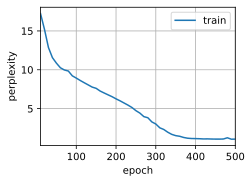

In [33]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 框架实现

In [36]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

困惑度 1.0, 114516.8 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


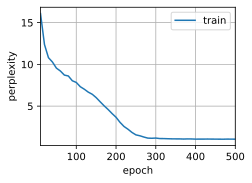

In [37]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 长短期记忆网络（LSTM）

长短期记忆网络（LSTM，Long Short-Term Memory）通过引入参数化的门控单元和细胞状态（Cell State）这一特殊结构，构建了一条非权重依赖的线性信息传播路径。它主要由三个门控单元（输入门、遗忘门和输出门）以及一个细胞状态组成。

- 输入门（Input Gate）：负责决定何时将当前时间步的输入信息写入记忆单元。当输入门开启时，新接收到的数据被整合到记忆单元中；反之，则阻止新的信息进入。
- 遗忘门（Forget Gate）：决定是否从LSTM状态中遗忘一些信息。这个门控单元在LSTM中起着至关重要的作用，因为它可以帮助网络忘记不重要的信息，从而避免信息过载。
- 输出门（Output Gate）：扮演着控制记忆单元内容何时及如何向后续时间步输出的角色。当输出门开启时，记忆单元中的信息得以传递至模型的下一层或下一时间步；反之，则屏蔽记忆单元的内容。

### 门控记忆单元

#### 输入门、忘记门和输出门

![长短期记忆模型中的输入门、遗忘门和输出门](../image/lstm-0.svg)

假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。
因此，输入为$\mathbf{X}_t \in \mathbb{R}^{n \times d}$，
前一时间步的隐状态为$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。
相应地，时间步$t$的门被定义如下：
输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$，
遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$，
输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。
它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

其中$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$是偏置参数。

#### 候选记忆元
![长短期记忆模型中的候选记忆元](../image/lstm-1.svg)

*候选记忆元*（candidate memory cell）
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。
它的计算与上面描述的三个门的计算类似，
但是使用$\tanh$函数作为激活函数，函数的值范围为$(-1, 1)$。
下面导出在时间步$t$处的方程：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

其中$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$和
$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数。

#### 记忆元
在长短期记忆网络中，输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据，
而遗忘门$\mathbf{F}_t$控制保留多少过去的
记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。
使用按元素乘法，得出：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

如果遗忘门始终为$1$且输入门始终为$0$，
则过去的记忆元$\mathbf{C}_{t-1}$
将随时间被保存并传递到当前时间步。
引入这种设计是为了缓解梯度消失问题，
并更好地捕获序列中的长距离依赖关系。

![在长短期记忆网络模型中计算记忆元](../image/lstm-2.svg)

#### 隐状态
我们需要定义如何计算隐状态
$\mathbf{H}_t \in \mathbb{R}^{n \times h}$，
这就是输出门发挥作用的地方。
在长短期记忆网络中，它仅仅是记忆元的$\tanh$的门控版本。
这就确保了$\mathbf{H}_t$的值始终在区间$(-1, 1)$内：

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

只要输出门接近$1$，我们就能够有效地将所有记忆信息传递给预测部分，
而对于输出门接近$0$，我们只保留记忆元内的所有信息，而不需要更新隐状态。

![在长短期记忆模型中计算隐状态](../image/lstm-3.svg)

### 从零开始实现

In [39]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

#### 初始化模型参数

In [40]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#### 定义模型

In [41]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [42]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

####  训练和预测

困惑度 1.1, 17920.0 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


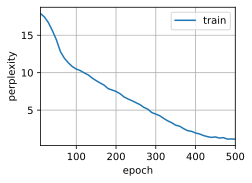

In [43]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 通过框架实现

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 深度循环神经网络

深度循环神经网络（Deep Recurrent Neural Network，简称Deep RNN）是循环神经网络（Recurrent Neural Network，简称RNN）的一种扩展形式。**使用多个隐藏层来获得更多的非线性性.**

具有$L$个隐藏层的深度循环神经网络

![深度循环神经网络结构](../image/deep-rnn.svg)

#### 函数依赖关系

假设在时间步$t$有一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数：$n$，每个样本中的输入数：$d$）。
同时，将$l^\mathrm{th}$隐藏层（$l=1,\ldots,L$）
的隐状态设为$\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$
（隐藏单元数：$h$），
输出层变量设为$\mathbf{O}_t \in \mathbb{R}^{n \times q}$
（输出数：$q$）。
设置$\mathbf{H}_t^{(0)} = \mathbf{X}_t$，
第$l$个隐藏层的隐状态使用激活函数$\phi_l$，则：

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$


其中，权重$\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$，
$\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$和
偏置$\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$
都是第$l$个隐藏层的模型参数。

最后，输出层的计算仅基于第$l$个隐藏层最终的隐状态：

$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$都是输出层的模型参数。

与多层感知机一样，隐藏层数目$L$和隐藏单元数目$h$都是超参数。

另外，用门控循环单元或长短期记忆网络的隐状态
来代替 深度循环网络中的隐状态进行计算，
可以很容易地得到深度门控循环神经网络或深度长短期记忆神经网络。

### 实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

## 双向循环神经网络（BiRNN）

双向循环神经网络（Bidirectional Recurrent Neural Network，简称BiRNN）是一种特殊的循环神经网络，它通过同时考虑正向和反向的序列信息来处理输入数据。

BiRNN由两个相互独立的RNN（循环神经网络）组成，分别为正向RNN和反向RNN。正向RNN从序列数据的头部开始处理，而反向RNN则从尾部开始处理。这两个RNN的输出向量在各时刻进行连接，从而形成一个完整的双向RNN。这种结构使得BiRNN能够同时考虑序列数据中的前后信息，捕捉更多的上下文信息。

### 双向模型
双向循环神经网络架构:

![双向循环神经网络架构](../image/birnn.svg)

#### 定义
对于任意时间步$t$，给定一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数$n$，每个示例中的输入数$d$），
并且令隐藏层激活函数为$\phi$。
在双向架构中，我们设该时间步的前向和反向隐状态分别为
$\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$和
$\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，
其中$h$是隐藏单元的数目。
前向和反向隐状态的更新如下：

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

其中，权重$\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$
和偏置$\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$都是模型参数。

接下来，将前向隐状态$\overrightarrow{\mathbf{H}}_t$
和反向隐状态$\overleftarrow{\mathbf{H}}_t$连接起来，
获得需要送入输出层的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$。
在具有多个隐藏层的深度双向循环神经网络中，
该信息作为输入传递到下一个双向层。
最后，输出层计算得到的输出为
$\mathbf{O}_t \in \mathbb{R}^{n \times q}$（$q$是输出单元的数目）：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

这里，权重矩阵$\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$
是输出层的模型参数。

#### 应用
双向层的使用在实践中非常少，并且仅仅应用于部分场合。 例如，填充缺失的单词、词元注释（例如，用于命名实体识别） 以及作为序列处理流水线中的一个步骤对序列进行编码
> 双向循环神经网络的计算速度非常慢。 其主要原因是网络的前向传播需要在双向层中进行前向和后向递归， 并且网络的反向传播还依赖于前向传播的结果。 因此，梯度求解将有一个非常长的链。
> 双向循环神经网络使用了过去的和未来的数据， 所以我们不能盲目地将这一语言模型应用于任何预测任务。 尽管模型产出的困惑度是合理的， 该模型预测未来词元的能力却可能存在严重缺陷。

### 代码实现

“bidirective=True”来定义双向LSTM模型

其实应用在这里的不合适，只是为了了解用法

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 机器翻译与数据集

In [44]:
import os
import torch
from d2l import torch as d2l

### 下载和预处理数据集

In [45]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

# 下载数据集 
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [46]:
# 预处理数据 ：我们用空格代替不间断空格（non-breaking space）， 使用小写字母替换大写字母，并在单词和标点符号之间插入空格。
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


### 词元化

In [47]:
# 此函数返回两个词元列表：source和target： source[i]是源语言（这里是英语）第i
# 个文本序列的词元列表， target[i]是目标语言（这里是法语）第i个文本序列的词元列表。
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

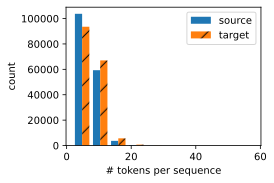

In [48]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

### 词表

In [49]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

### 加载数据集

In [50]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [51]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

### 训练模型

In [52]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [53]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 60, 102,   2,   4,   5,   5,   5,   5],
        [ 58,  38,   2,   4,   5,   5,   5,   5]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[32, 42,  0,  4,  5,  5,  5,  5],
        [ 6,  0,  4,  5,  5,  5,  5,  5]], dtype=torch.int32)
Y的有效长度: tensor([4, 3])


## 编码器-解码器架构

编码器-解码器（encoder-decoder）架构包含两个主要组件的架构： 第一个组件是一个编码器（encoder）： 它接受一个长度可变的序列作为输入， 并将其转换为具有固定形状的编码状态。 第二个组件是解码器（decoder）： 它将固定形状的编码状态映射到长度可变的序列。

![编码器-解码器架构](../image/encoder-decoder.svg)

“编码器－解码器”架构可以将长度可变的序列作为输入和输出，因此适用于机器翻译等序列转换问题。

### 重新认识CNN和RNN
![cnn_encoder_decoder](../image/cnn_encoder_decoder.png)

![rnn_encoder_decoder](../image/rnn_encoder_decoder.png)

### 编码器

In [54]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError
        

### 解码器

In [ ]:
#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [ ]:
#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## 序列到序列学习（seq2seq）

循环神经网络编码器使用长度可变的序列作为输入， 将其转换为固定形状的隐状态。为了连续生成输出序列的词元， 独立的循环神经网络解码器是基于输入序列的编码信息 和输出序列已经看见的或者生成的词元来预测下一个词元。

![使用循环神经网络编码器和循环神经网络解码器的序列到序列学习](../image/seq2seq.svg)

In [55]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

### 编码器

In [56]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [57]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

### 解码器

In [58]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [59]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

上述循环神经网络“编码器－解码器”模型中的各层如 图所示：

![循环神经网络编码器-解码器模型中的层](../image/seq2seq-details.svg)


### 损失函数

In [60]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [61]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [62]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

### 训练

In [70]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat= net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 6823.6 tokens/sec on cuda:0


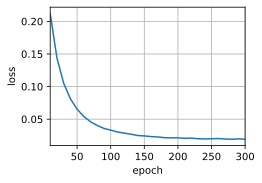

In [71]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### 预测

In [65]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

### 预测序列的评估

我们可以通过与真实的标签序列进行比较来评估预测序列。

BLEU 衡量生成序列的好坏。

BLEU定义为：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
第一个是预测序列与标签序列中匹配的$n$元语法的数量，
第二个是预测序列中$n$元语法的数量的比率。
具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$、$B$、$C$、$D$，
我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

In [66]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [72]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis calme !, bleu 0.418


### 总结
- Seq2seq从一个句子生成另一个句子
- 编码器和解码器都是RNN
- 将编码器最后时间隐状态来初始解码器隐状态来完成信息传递
- 常用BLEU来衡量生成序列的好坏

## 束搜索
序列搜索策略包括贪心搜索、穷举搜索和束搜索。

### 贪心搜索（greedy search）
在seq2seq中我们使用了贪心搜索来预测序列：将当前时刻预测概率最大的词输出

但贪心很可能不是最优的: 每个时刻最优，不代表最终结果是最优的
![贪心搜索](../image/greedy_search.png)

### 穷举搜索（exhaustive search）
穷举地列举所有可能的输出序列及其条件概率， 然后计算输出条件概率最高的一个。。
如果输出字典大小为$n$,序列最长为$T$那么我们需要考察$n^T$个序列。
比如：n=10000，T=10 : $n^T=10^40$,计算量太大

### 束搜索（beam search）

保存最好的k个候选，在每个时刻，对每个候选新加一项(n种可能)，在 kn个选项中选出最好的k个

![束搜索过程（束宽：2，输出序列的最大长度：3）。候选输出序列是$A$、$C$、$AB$、$CE$、$ABD$和$CED$](../image/beam-search.svg)


每个候选最终分数计算：

$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}\mid \mathbf{c}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}),$$


其中$L$是最终候选序列的长度，
$\alpha$通常设置为$0.75$。

束搜索的计算量为$\mathcal{O}(k\left|\mathcal{Y}\right|T')$，
这个结果介于贪心搜索和穷举搜索之间

- k=5时 $ n=10000,T=10 knT=5*10^5$

- k=1时是贪心搜索

- k=n时是穷举搜索




In [ ]:
贪心搜索所选取序列的计算量最小，但精度相对较低。

穷举搜索所选取序列的精度最高，但计算量最大。

束搜索通过灵活选择束宽，在正确率和计算代价之间进行权衡。